In [5]:
import sklearn
import torch
from torch import nn
from helper_functions import plot_decision_boundary, plot_predictions
import matplotlib.pyplot as plt

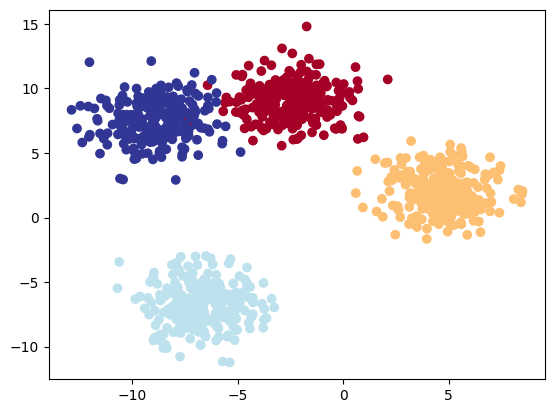

In [11]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyper parameters for data creation
NUM_CLASSES  = 4
NUM_FEATURES = 2

X, y= make_blobs(n_samples =1000, 
                 n_features=2, # X features
                 centers= NUM_CLASSES, # y labels
                 cluster_std=1.5, 
                 random_state=42)
plt.scatter(X[:,0], X[:,1],c=y, cmap=plt.cm.RdYlBu)

In [65]:
## Convert array to tensor and split the data into train and test
X_blob = torch.from_numpy(X).type(torch.float)
y_blob = torch.from_numpy(y).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

print(len(X_blob_train), len(X_blob_test), len(y_blob_test), len(y_blob_train))


800 200 200 800


In [66]:
## Build a model for multiclass classification
## Set the hyper parameters

IN_FEATURES= 2
OUT_FEATURES = 4
HIDDEN_UNITS =10

class BlobModulev0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)



In [67]:
## Create the Model
Model_0 = BlobModulev0(input_features=IN_FEATURES, output_features=OUT_FEATURES, hidden_units=HIDDEN_UNITS)
#Model_0.state_dict()

In [68]:
## Creating a Loss function and Optimizer for the Model

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=Model_0.parameters(), lr= 0.1)

In [62]:
# Check the Model to see the output before training

Model_0(X_blob_test)[2]

## Model is predicting values that are called "logits" -> prediction probabilities -> prediction labels

## For Multiclass classification : The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

tensor([-0.2102,  1.4290,  0.4555,  0.0992], grad_fn=<SelectBackward0>)

In [63]:
# Calculate the accuracy of the model for Binary classification

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct /len(y_pred)) * 100
    return acc


In [70]:
## Create a training and testing loop for the model fitting

epochs = 100

for epoch in range(epochs):
    ##1. Put the Model in training Mode
    Model_0.train()

    ##2. Forward pass function to call the classfication
    y_logits = Model_0.forward(X_blob_train)
    ## change the logits to predictions
    y_pred = torch.argmax(torch.softmax(y_logits, dim =1), dim =1)

    ##3. Calculate the loss
    loss = loss_function(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train, y_pred= y_pred)

    ##4. Zero gradient - reset
    optimizer.zero_grad()

    ##5. backward propagation
    loss.backward()

    ##6. Optimizer step to adjust the parameters of the model
    optimizer.step()

    ## Testing mode
    Model_0.eval()
    with torch.inference_mode():
        test_logits = Model_0(X_blob_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

        test_loss = loss_function(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test, y_pred= test_pred)

    ## print the results
    if epoch %10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 





Epoch: 0 | Loss: 1.62261, Acc: 24.12% | Test Loss: 1.25623, Test Acc: 28.50%
Epoch: 10 | Loss: 0.65268, Acc: 81.88% | Test Loss: 0.58009, Test Acc: 90.00%
Epoch: 20 | Loss: 0.38379, Acc: 78.88% | Test Loss: 0.55409, Test Acc: 71.00%
Epoch: 30 | Loss: 0.11292, Acc: 99.12% | Test Loss: 0.10265, Test Acc: 99.00%
Epoch: 40 | Loss: 0.07131, Acc: 99.00% | Test Loss: 0.06386, Test Acc: 99.00%
Epoch: 50 | Loss: 0.05538, Acc: 99.00% | Test Loss: 0.04854, Test Acc: 99.00%
Epoch: 60 | Loss: 0.04723, Acc: 99.00% | Test Loss: 0.04034, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04231, Acc: 99.00% | Test Loss: 0.03523, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03906, Acc: 99.00% | Test Loss: 0.03174, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03677, Acc: 99.00% | Test Loss: 0.02921, Test Acc: 99.50%


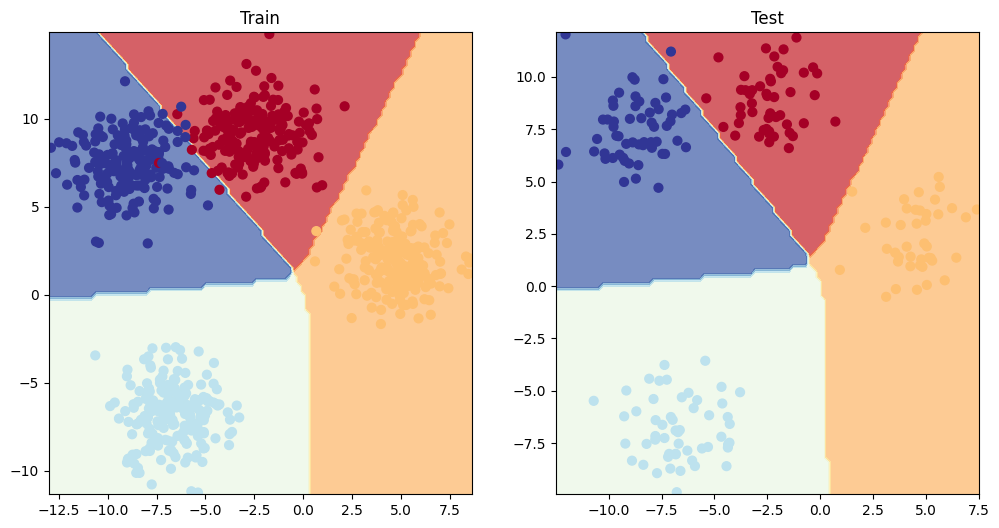

In [71]:
## Visualize the prediction

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_0, X_blob_test, y_blob_test)

In [76]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

In [79]:
accuracy = Accuracy(task='multiclass',num_classes=4)
accuracy(test_pred, y_blob_test)

tensor(0.9950)